# Predictions

In [1]:
#Numpy
import numpy as np
from numpy import median

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
from matplotlib.ticker import ScalarFormatter

#Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

#Scipy
from scipy.sparse import csr_matrix

#Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading in the data from the previous notebook
fd = pd.read_csv('Predictions')

In [3]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order #         46062 non-null  int64  
 1   Product Total   46062 non-null  float64
 2   Grand Total     46062 non-null  float64
 3   Delivery Year   46062 non-null  int64  
 4   Delivery Day    46062 non-null  int64  
 5   Delivery Month  46062 non-null  int64  
 6   Order Year      46062 non-null  int64  
 7   Order Day       46062 non-null  int64  
 8   Order Month     46062 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.2 MB


## **Making Predictions with RFG**

In [4]:
# Drop the target column to separate it from the features
X = fd.drop(columns='Product Total')
y = fd['Product Total']

In [5]:
#Split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')

#Scaler
scaler = StandardScaler()

#OneHotEncoder
ohe =OneHotEncoder(handle_unknown='ignore', sparse=True)

#Create Selectors
cat_selector = make_column_selector(dtype_include= 'object')
num_selector = make_column_selector(dtype_include='number')

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

#cat pipe
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

#Make tuples for preprocessing the categorical and numeric columns
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)          

In [7]:
#Create Column Transformer
preprocessor= make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [8]:
# Preprocess the data
# Fit and transform the preprocessing on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

In [9]:
# Looking at how the preprocessor is organized
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023600368670>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023600368160>)])

In [10]:
#Random forrest Regressor Pipeline
#Fitting the pipeline
rf_tree_pipe = make_pipeline(preprocessor,RandomForestRegressor(random_state = 42))
rf_tree_pipe.fit(X_train, y_train)

# Get predictions for training and test data
y_hat_train = rf_tree_pipe.predict(X_train)
y_hat_test = rf_tree_pipe.predict(X_test)

In [11]:
#Function for evaluating Model preformance
def evaluate_model(y_true, y_pred, split='training'):
  """ prints RMSE, and R2 metrics, include which data split was evaluated

  Args:
    y_true: y-train or y-test
    y_pred: result of model.predict(X)
    split: which data split is being evaluate ['training','test']
  """

  r2 = r2_score(y_true,y_pred)
  mae = mean_absolute_error(y_true,y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true,y_pred,squared=False)


  print(f'Results for {split} data:')
  print(f"  - R^2 = {round(r2,3)}")
  print(f"  - MAE = {round(mae,3)}")
  print(f"  - MSE = {round(mse,3)}")
  print(f"  - RMSE = {round(rmse,3)}")
  print()

In [12]:
# Evaluate model's performance
evaluate_model(y_train, y_hat_train,split='training')
evaluate_model(y_test, y_hat_test,split='testing')

Results for training data:
  - R^2 = 0.994
  - MAE = 3.016
  - MSE = 221.097
  - RMSE = 14.869

Results for testing data:
  - R^2 = 0.937
  - MAE = 8.03
  - MSE = 1872.78
  - RMSE = 43.276



In [13]:
#create a range of max_depth values
n_estimators = [202, 203, 204, 205, 206, 207, 208]

max_depths = [5, 10, 15] 

#create a dataframe to store train and test scores.
scores = pd.DataFrame(index=n_estimators)

# Loop over the values in n_estimators
for n in n_estimators:
    for max_depth in max_depths:
        # Fit a new model with max_depth
        rf = RandomForestRegressor(random_state=42, n_estimators=n, max_depth=max_depth)

        # Put the model into a pipeline
        rf_pipe = make_pipeline(preprocessor, rf)

        # Fit the model
        rf_pipe.fit(X_train, y_train)

        # Create prediction arrays
        train_pred = rf_pipe.predict(X_train)
        test_pred = rf_pipe.predict(X_test)

        # Evaluate the model using R2 Score
        train_r2score = r2_score(y_train, train_pred)
        test_r2score = r2_score(y_test, test_pred)

        # Store the scores in the scores dataframe
        scores.loc[n, f'Train (max_depth={max_depth})'] = train_r2score
        scores.loc[n, f'Test (max_depth={max_depth})'] = test_r2score

# Print the scores dataframe
print(scores)

     Train (max_depth=5)  Test (max_depth=5)  Train (max_depth=10)  \
202             0.970970            0.934562              0.989080   
203             0.970961            0.934571              0.989056   
204             0.970957            0.934571              0.989058   
205             0.970959            0.934597              0.989059   
206             0.970981            0.934566              0.989069   
207             0.970993            0.934584              0.989089   
208             0.971008            0.934617              0.989093   

     Test (max_depth=10)  Train (max_depth=15)  Test (max_depth=15)  
202             0.938154              0.993461             0.937557  
203             0.938033              0.993431             0.937410  
204             0.938044              0.993426             0.937438  
205             0.938065              0.993431             0.937477  
206             0.938066              0.993453             0.937485  
207             0.9

In [14]:
#Obtaining the traing and test scores for random forest regression model
best_rf = RandomForestRegressor(random_state = 42, n_estimators = n, max_depth=5)

best_rf_pipe = make_pipeline(preprocessor, best_rf)

best_rf_pipe.fit(X_train, y_train)

print('Training Scores for Random Forest Regressor')
evaluate_model(y_train, best_rf_pipe.predict(X_train), split = 'training')

print('\n')

print('Testing Scores for Random forest Regressor')
evaluate_model(y_test, best_rf_pipe.predict(X_test), split = 'testing')

Training Scores for Random Forest Regressor
Results for training data:
  - R^2 = 0.971
  - MAE = 10.424
  - MSE = 1047.421
  - RMSE = 32.364



Testing Scores for Random forest Regressor
Results for testing data:
  - R^2 = 0.935
  - MAE = 10.684
  - MSE = 1932.193
  - RMSE = 43.957



In [15]:
# Use the trained model to make predictions on your dataset 'fd'
predictions = best_rf.predict(fd.drop(columns=['Product Total']))

# Create a new DataFrame with the predictions and 'Year' column (assuming 'Year' is one of the columns in your dataset)
predictions_df = pd.DataFrame({'Order Year': fd['Order Year'], 'Predicted Product Total': predictions})

# Group the predictions by 'Year' and calculate the mean of 'Predicted Product Total' for each year
predictions_grouped = predictions_df.groupby('Order Year')['Predicted Product Total'].mean().reset_index()

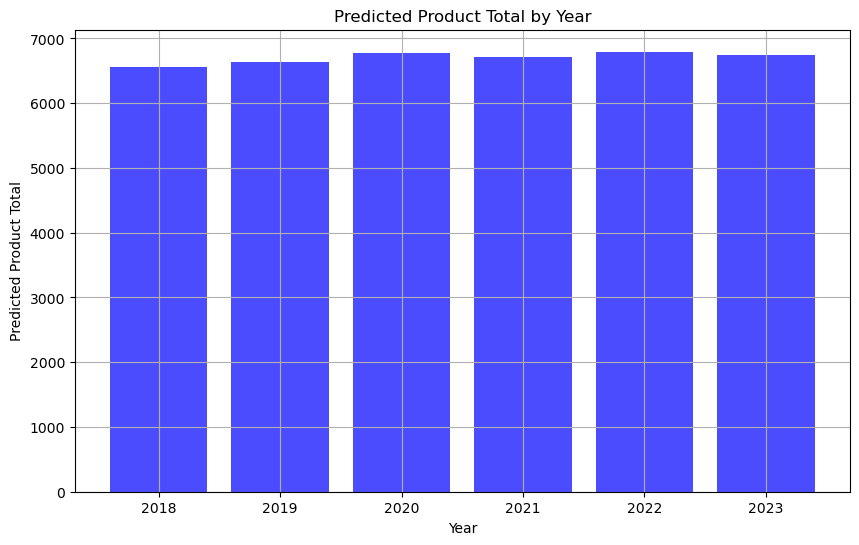

In [17]:
# Create a bar plot for the predicted 'Product Total' by year
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(predictions_grouped['Order Year'], predictions_grouped['Predicted Product Total'], color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Predicted Product Total')
plt.title('Predicted Product Total by Year')
plt.grid(True)

# Show the plot
plt.show()